# Example Climb: Pearson & Spearman correlation coefficients

## 1. Notebook setup

### 1.1. Imports

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [ ]:
# Number of input data points
n = 1000

# Run duration in minutes
run_time = 5

# Replica exchange parameters
n_replicas = 4
temperature = 100  # T_min (coldest replica)
T_max = 1000  # T_max (hottest replica)

# Hill climb parameters
step_spread = 0.001
perturb_fraction = 0.01
cooling_rate = 1e-5

### 1.3. Input distributions

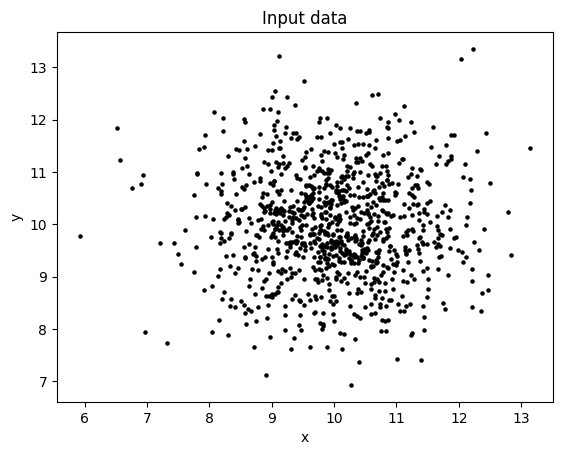

In [3]:
# Create input distribution
data = pd.DataFrame({
    'x': np.random.normal(10, 1, n),
    'y': np.random.normal(10, 1, n)
})

plt.title('Input data')
plt.scatter(data['x'], data['y'], s=5, color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 2. Strong Spearman, weak Pearson
### 2.1. Objective function

In [4]:
def objective_spearman_large_pearson_small(x, y):
    '''Maximize Spearman correlation while minimizing Pearson correlation.
    
    Objective function: |Spearman| - |Pearson|
    
    This encourages:
        - Small Pearson correlation (close to 0)
        - Large Spearman correlation (close to +/-1)
    
    Useful for finding non-linear monotonic relationships.
    
    Args:
        x: First variable (array-like)
        y: Second variable (array-like)
    
    Returns:
        Tuple of (metrics_dict, objective_value) where:
            - metrics_dict: Dict with 'Pearson coefficient' and 'Spearman coefficient'
            - objective_value: |Spearman| - |Pearson|
    '''
    
    pearson_corr = pearsonr(x, y)[0]
    spearman_corr = spearmanr(x, y)[0]
    objective = abs(spearman_corr) - abs(pearson_corr)
    
    metrics = {
        'PCC': pearson_corr,
        'SCC': spearman_corr
    }
    
    return metrics, objective

### 2.2. Hill climbing run


Plotting progress at 5 minutes...


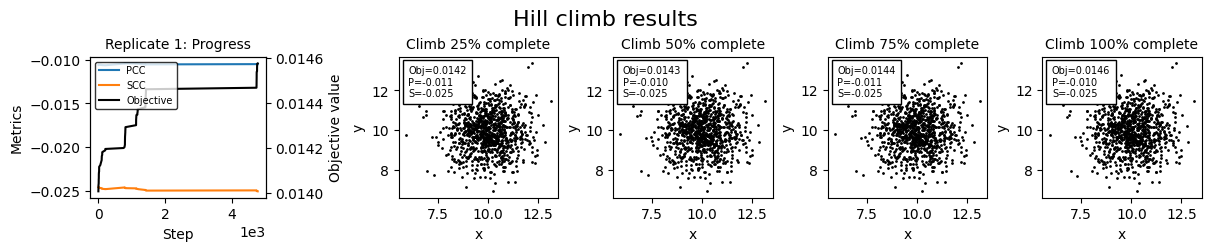

In [ ]:
# Create HillClimber instance with replica exchange
climber = HillClimber(
    data=data,
    objective_func=objective_spearman_large_pearson_small,
    max_time=run_time,
    step_spread=step_spread,
    perturb_fraction=perturb_fraction,
    temperature=temperature,
    T_max=T_max,
    n_replicas=n_replicas,
    cooling_rate=cooling_rate,
    mode='maximize',
    plot_progress=1
)

# Run optimization
best_data, history_df = climber.climb()

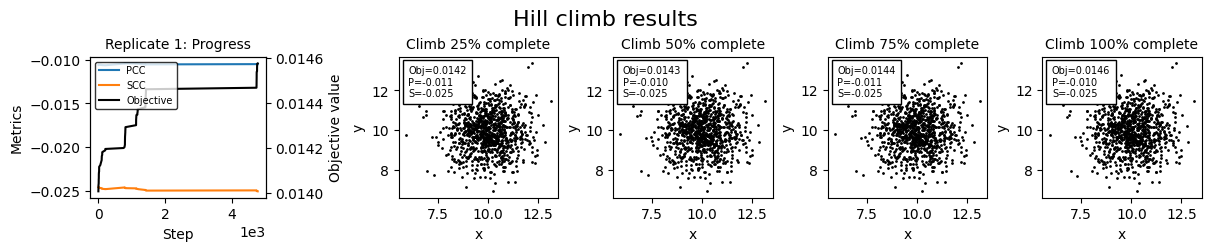

In [ ]:
climber.plot_results(
    (best_data, history_df),
    plot_type='scatter', 
    metrics=[
        'PCC',
        'SCC',
    ]
)

### 2.3. Save

In [7]:
# Save the climber object
with open('../data/02.pearson_low_spearman_high.pkl', 'wb') as f:
    pickle.dump(climber, f)